## Import

In [1]:
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as torchdata
from torchvision.transforms import transforms
from torchinfo import summary

In [2]:
import netCDF4 as nc
import seaborn.colors.xkcd_rgb as c

## Utilities

In [3]:
myseed = 42
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

In [4]:
def get_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data

In [36]:
class PBLDataset():
    def __init__(self, lu:str, proportion_list:list, jump_time:int=1):
        self.lu          = lu         # land type
        self.jump_time   = jump_time  # mapped adjustment time interval, defautl=1
        self.propo_list  = proportion_list  # train/(val)/test proportion

        self.day_num     = 3
        self.ts_cover    = (0, 391+self.jump_time)  # 5:00 - 18:00 + jump time
        self.ts_state_1d = (0, 391)                 # state (input) time cover, 1 day
        
        # Read data into numpy arrays (tsteps, var, lev)
        ncs1 = nc.Dataset(f'/home/ch995334/2024ClDyn/TemporaryData/lu_profs/{lu}_1p0km.nc')
        ncs2 = nc.Dataset(f'/home/ch995334/2024ClDyn/TemporaryData/lu_profs/{lu}_1p5km.nc')
        ncs3 = nc.Dataset(f'/home/ch995334/2024ClDyn/TemporaryData/lu_profs/{lu}_2p0km.nc')
        th_all_sd = np.concatenate((ncs1.variables['th'][:self.ts_state_1d[1], :].data, 
                                    ncs2.variables['th'][:self.ts_state_1d[1], :].data, 
                                    ncs3.variables['th'][:self.ts_state_1d[1], :].data), axis=0)
        self.th_all_sd = th_all_sd
        th_diff_all_sd = np.concatenate((ncs1.variables['th'][self.jump_time:self.ts_cover[1], :].data-ncs1.variables['th'][:self.ts_state_1d[1], :].data, 
                                         ncs2.variables['th'][self.jump_time:self.ts_cover[1], :].data-ncs2.variables['th'][:self.ts_state_1d[1], :].data, 
                                         ncs3.variables['th'][self.jump_time:self.ts_cover[1], :].data-ncs3.variables['th'][:self.ts_state_1d[1], :].data), axis=0)
        # Shuffle-split index (the given proportion should be applied to all soundings)
        subset_idx   = []
        for d in range(self.day_num):
            day_idx = np.arange(self.ts_state_1d[1]*(d), self.ts_state_1d[1]*(d+1))
            np.random.shuffle(day_idx)
            if d == 0:
                subset_idx = np.split(day_idx, np.cumsum((np.array(self.propo_list)*day_idx.shape[0])[:-1]).astype(int))
            else:
                temp       = np.split(day_idx, np.cumsum((np.array(self.propo_list)*day_idx.shape[0])[:-1]).astype(int))
                for i in range(len(self.propo_list)):
                    subset_idx[i] = np.append(subset_idx[i], temp[i])
        self.subset_idx= tuple(subset_idx)
        # Normalization (whole-set), save Input and Target scalars
        self.th_min, self.th_max           = np.min(th_all_sd), np.max(th_all_sd)
        self.th_diff_min, self.th_diff_max = np.min(th_diff_all_sd), np.max(th_diff_all_sd)
        th_norm      = (th_all_sd-self.th_min)/(self.th_max-self.th_min)
        th_diff_norm = (th_diff_all_sd-self.th_diff_min)/(self.th_diff_max-self.th_diff_min)
        
        # Create data tensor and dataset
        if len(self.propo_list) == 3:
            self.TrainIdx,   self.ValIdx,   self.TestIdx   = self.subset_idx
            self.InputTrain, self.InputVal, self.InputTest = torch.FloatTensor(th_norm[self.trainIdx, np.newaxis, :]),\
                                                             torch.FloatTensor(th_norm[self.valIdx, np.newaxis, :]),\
                                                             torch.FloatTensor(th_norm[self.testIdx, np.newaxis, :])
            self.TargetTrain,self.TargetVal,self.TargetTest= torch.FloatTensor(th_diff_norm[self.trainIdx, np.newaxis, :]),\
                                                             torch.FloatTensor(th_diff_norm[self.valIdx, np.newaxis, :]),\
                                                             torch.FloatTensor(th_diff_norm[self.testIdx, np.newaxis, :])
            
            self.TrainDataset = torchdata.TensorDataset(self.InputTrain, self.TargetTrain)
            self.ValDataset   = torchdata.TensorDataset(self.InputVal, self.TargetVal)
            self.TestDataset  = torchdata.TensorDataset(self.InputTest, self.TargetTest)
        elif len(self.propo_list) == 2:
            self.trainIdx,   self.testIdx   = self.subset_idx
            self.InputTrain, self.InputTest = torch.FloatTensor(th_norm[self.trainIdx, np.newaxis, :]),\
                                              torch.FloatTensor(th_norm[self.testIdx, np.newaxis, :])
            self.TargetTrain,self.TargetTest= torch.FloatTensor(th_diff_norm[self.trainIdx, np.newaxis, :]),\
                                              torch.FloatTensor(th_diff_norm[self.testIdx, np.newaxis, :])
            
            self.TrainDataset = torchdata.TensorDataset(self.InputTrain, self.TargetTrain)
            self.TestDataset  = torchdata.TensorDataset(self.InputTest, self.TargetTest)
        print(f"Finished creating the PBL dataset for land type {lu.upper()}.")
        print(f"Current input:  theta state profile")
        print(f"Current target: theta adjustemnt with jump-time = {self.jump_time}")

## NN Model

### Model structure

In [7]:
class CNN1D(nn.Module):
    def __init__(self, input_var_num:int):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_var_num, out_channels=16, kernel_size=3, stride=1) # no padding, -2
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1)  # no padding, -2
        self.fc1 = nn.Linear(32*71, 64)  # 71 = 75-2-2
        self.fc2 = nn.Linear(64, 75)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model_demo = CNN1D(input_var_num=1)
summary(model_demo, input_size=(32,1,75), device="cuda")

Layer (type:depth-idx)                   Output Shape              Param #
CNN1D                                    [32, 75]                  --
├─Conv1d: 1-1                            [32, 16, 73]              64
├─ReLU: 1-2                              [32, 16, 73]              --
├─Conv1d: 1-3                            [32, 32, 71]              1,568
├─ReLU: 1-4                              [32, 32, 71]              --
├─Flatten: 1-5                           [32, 2272]                --
├─Linear: 1-6                            [32, 64]                  145,472
├─ReLU: 1-7                              [32, 64]                  --
├─Linear: 1-8                            [32, 75]                  4,875
Total params: 151,979
Trainable params: 151,979
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 8.52
Input size (MB): 0.01
Forward/backward pass size (MB): 0.92
Params size (MB): 0.61
Estimated Total Size (MB): 1.53

### Training func

In [13]:
def train(model_to_train, train_loader, val_loader, config:dict, device):
    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = getattr(torch.optim, config['optimizer'])(model_to_train.parameters(), **config['optim_hparas'])
    # Training loop
    loss_log  = {'train':[], 'val':[]}
    for epoch in range(config['epochs']):
        model_to_train.train()
        train_loss  = 0
        for inputs, targets in train_loader:   # batch = (inputs, targets)
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.float)
            optimizer.zero_grad()
            outputs = model_to_train(inputs)
            loss    = criterion(outputs, targets)
            loss.backward()    # back propagate gradient
            optimizer.step()   # update model with opitmizer
            train_loss += loss.item()
        loss_log['train'].append(train_loss / len(train_loader))  # loss averaged over batches

        # Validation
        model_to_train.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.float)
                outputs = model_to_train(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        loss_log['val'].append(val_loss/len(val_loader))
        # Print loss on screen
        if epoch%10 == 0:
            print(f"Epoch {epoch + 1}/{config['epochs']}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")
    return model_to_train, loss_log

### Prediction func

In [22]:
def predict(trained_model, test_loader, device):
    # Get prediction
    trained_model.eval()
    counter = 0
    with torch.no_grad():                     # disable gradient descend
        for batch in test_loader:
            if len(batch) == 2:
                inputs, targets = batch
            elif len(batch) == 1:
                inputs = batch[0]
            inputs = inputs.to(device, dtype=torch.float)
            pred   = trained_model(inputs)
            if counter < 1:
                preds = pred.detach().cpu().numpy()
                print(preds.shape)
            else:
                preds = np.concatenate((preds, pred.detach().cpu().numpy()), axis=0)
            counter += 1
    return preds

### Save and Load models

In [20]:
def save_model(model, savepath:str):
    model.eval()
    torch.save(model.state_dict(), f"{savepath}_state.pt")

In [21]:
def load_model(model_instance, savepath:str):
    """
    `model_instance` should be the exact same in structure with what this function is loading.
    """
    model_instance.load_state_dict(torch.load(f"{savepath}_state.pt", weights_only=True))
    return model_instance

## Main

### Setup hparams config

In [11]:
config = {'epochs':200, 
          'batch_size':32, 
          'optimizer':'Adam', 
          'optim_hparas':{'lr':0.001}}

In [41]:
device = get_device()
print(device)

cuda


### Generate data and initiate model

In [ ]:
def GenerateData(lu:str):
case_data = PBLDataset(lu)
trainset, testset

return data_dict

In [ ]:
model_init

### Start Training!

In [ ]:
train_loader = torchdata.dataloader(data_dict['TrainDataset'], batch_size=config['batch_size'])
test_loader  = torchdata.dataloader(data_dict['TestDataset'], batch_size=1)
trained_model, loss_log = train(model_init, train_loader, test_loader, device)
trained_model.eval()
prediction   = predict(trained_model, test_loader, device)
nn_dict      = {'trained_model':, 'loss_log':, 'prediction':}

(Optional) Save trained model

In [ ]:
save_model(trained_model, savepath=)
del trained_model

## Test

### Thoughts dump

In [10]:
getattr(torch.optim, 'Adam')

torch.optim.adam.Adam

In [29]:
a = np.arange(10)
np.random.shuffle(a)

In [32]:
np.split(a, np.cumsum((np.array([0.8, 0.2])*a.shape[0])[:-1]).astype(int))
# np.split(day_idx, np.cumsum((np.array(self.propo_list)*day_idx.shape[0])[:-1]).astype(int))

[array([2, 9, 0, 7, 4, 6, 1, 5]), array([8, 3])]

In [33]:
np.append(np.arange(5), np.ones(4))

array([0., 1., 2., 3., 4., 1., 1., 1., 1.])

### Dataset Class

In [37]:
ds_class_temp = PBLDataset(lu='pb', proportion_list=[0.8, 0.2])

Finished creating the PBL dataset for land type PB.
Current input:  theta state profile
Current target: theta adjustemnt with jump-time = 1


In [38]:
ds_class_temp.TrainDataset

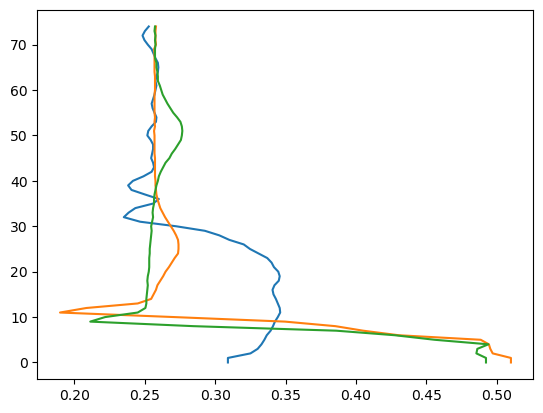

In [13]:
plt.plot(ds_class_temp.TargetTest[5, 0, :], np.arange(75))
plt.plot(ds_class_temp.TargetTest[35, 0, :], np.arange(75))
plt.plot(ds_class_temp.TargetTest[200, 0, :], np.arange(75))